In [18]:
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import matplotlib.animation as animation
from matplotlib.colors import ListedColormap
from IPython.display import Image

In [3]:
class NeighborhoodType(Enum):
    CROSS = 0  
    NEUMAN = 1 
class CellColor(Enum):
    EMPTY = 0
    FIRING = 1
    TREE = 2

In [4]:
def create_ca(w:int, h:int):
    return np.zeros((h, w), dtype=int)

def init_state(ca: np.ndarray, eta: float, f: int, rs: np.random.RandomState):
    h, w = ca.shape
    size = h * w
    trees_count = int(eta * size)
    idx = rs.choice(size, trees_count, replace=False)
    ca.flat[idx] = CellColor.TREE.value
    fire_idx = rs.choice(idx, f, replace=False)
    ca.flat[fire_idx] = CellColor.FIRING.value
    return ca


In [5]:
def get_cross_neighborhood(cell, cashape):
    i, j = cell
    h, w = cashape
    neighbors = []
    for di, dj in [(-1,0), (1,0), (0,-1), (0,1)]:
        ni, nj = i+di, j+dj
        if 0 <= ni < h and 0 <= nj < w:
            neighbors.append((ni, nj))
    return neighbors

def get_neuman_neighborhood(cell, cashape):
    i, j = cell
    h, w = cashape
    neighbors = []
    for di in [-1,0,1]:
        for dj in [-1,0,1]:
            if di == 0 and dj == 0:
                continue
            ni, nj = i+di, j+dj
            if 0 <= ni < h and 0 <= nj < w:
                neighbors.append((ni, nj))
    return neighbors


In [6]:
def update_cell(ca, new_ca, cell, neighborindexes, rs, pf, pg):
    i, j = cell
    if ca[i, j] == CellColor.FIRING.value:
        new_ca[i, j] = CellColor.EMPTY.value
    elif ca[i, j] == CellColor.TREE.value:
        if any(ca[ni, nj] == CellColor.FIRING.value for (ni, nj) in neighborindexes):
            new_ca[i, j] = CellColor.FIRING.value
        elif rs.rand() < pf:
            new_ca[i, j] = CellColor.FIRING.value
        else:
            new_ca[i, j] = CellColor.TREE.value
    elif ca[i, j] == CellColor.EMPTY.value:
        if all(ca[ni, nj] != CellColor.FIRING.value for (ni, nj) in neighborindexes) and rs.rand() < pg:
            new_ca[i, j] = CellColor.TREE.value
        else:
            new_ca[i, j] = CellColor.EMPTY.value


In [7]:
def update_ca(ca, nt, rs, pf, pg):
    h, w = ca.shape
    new_ca = np.copy(ca)
    for i in range(h):
        for j in range(w):
            cell = (i, j)
            if nt == NeighborhoodType.CROSS:
                neighbors = get_cross_neighborhood(cell, ca.shape)
            else:
                neighbors = get_neuman_neighborhood(cell, ca.shape)
            update_cell(ca, new_ca, cell, neighbors, rs, pf, pg)
    return new_ca


In [8]:
class Statistics:
    def __init__(self):
        self.t = []
        self.af = []
        self.at = []
        self.ae = []
    def append(self, t, ca):
        self.t.append(t)
        self.af.append((ca == CellColor.FIRING.value).sum())
        self.at.append((ca == CellColor.TREE.value).sum())
        self.ae.append((ca == CellColor.EMPTY.value).sum())


In [9]:
def simulate_ca(ca, nt, rs, pf, pg, time):
    st = Statistics()
    for t in range(time):
        st.append(t, ca)
        ca = update_ca(ca, nt, rs, pf, pg)
    return st


In [10]:
def plot_statistics(stats, title):
    plt.figure(figsize=(10,6))
    plt.plot(stats.t, stats.af, label='Горящие')
    plt.plot(stats.t, stats.at, label='Деревья')
    plt.plot(stats.t, stats.ae, label='Пустые')
    plt.legend()
    plt.title(title)
    plt.xlabel('Время')
    plt.ylabel('Количество')
    plt.show()


In [20]:
def animate_fire_evolution(ca, nt, rs, pf, pg, time, interval=50, filename="fire_evolution.gif"):
    fig, ax = plt.subplots(figsize=(8,8))
    cmapforest = ListedColormap(['#49423D', 'orange', 'green'])  # пусто, горит, дерево
    state = np.copy(ca)
    im = ax.imshow(state, cmap=cmapforest)
    title = ax.set_title("")

    def update(frame):
        nonlocal state
        ax.set_xlabel("Length")
        ax.set_ylabel("Width")
        ax.set_title(f"Время: {frame}")
        im.set_data(state)
        state = update_ca(state, nt, rs, pf, pg)
        return [im, title]

    ani = animation.FuncAnimation(fig, update, frames=time, interval=interval, blit=True)
    ani.save(filename, writer='pillow')
    plt.close(fig)
    print(f"Анимация сохранена как {filename}")

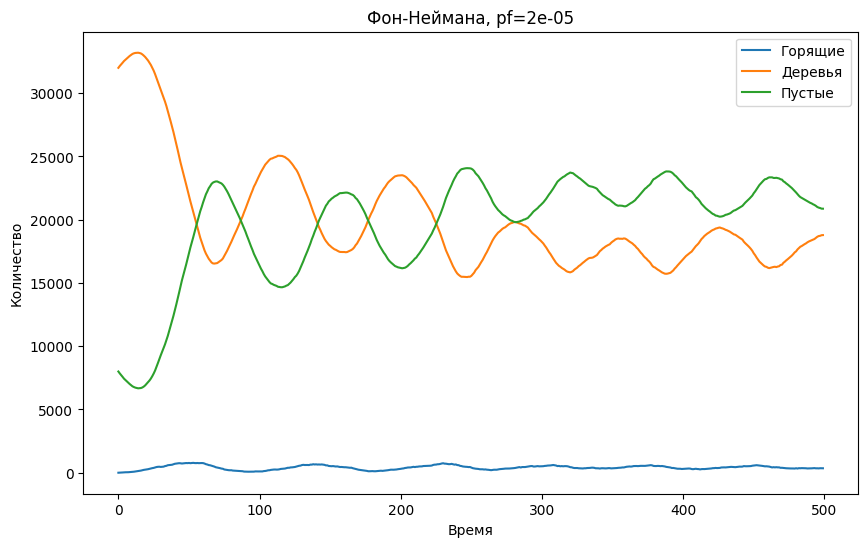

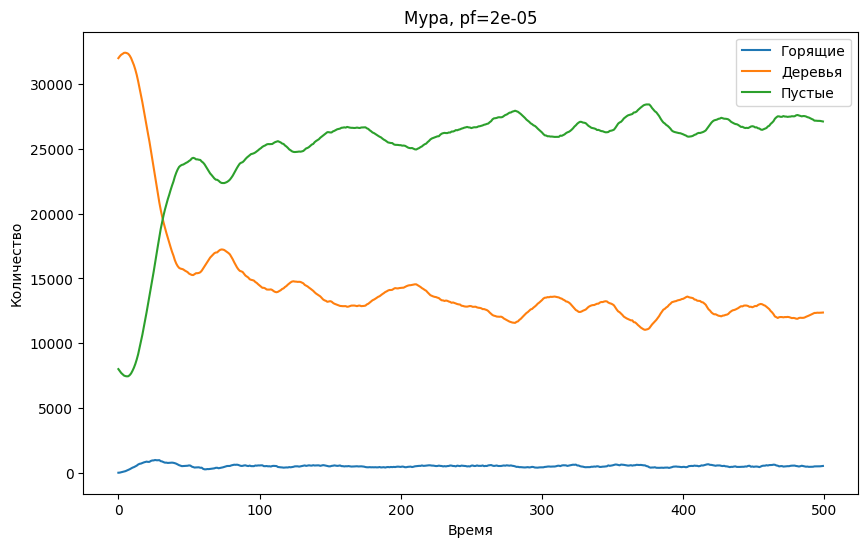

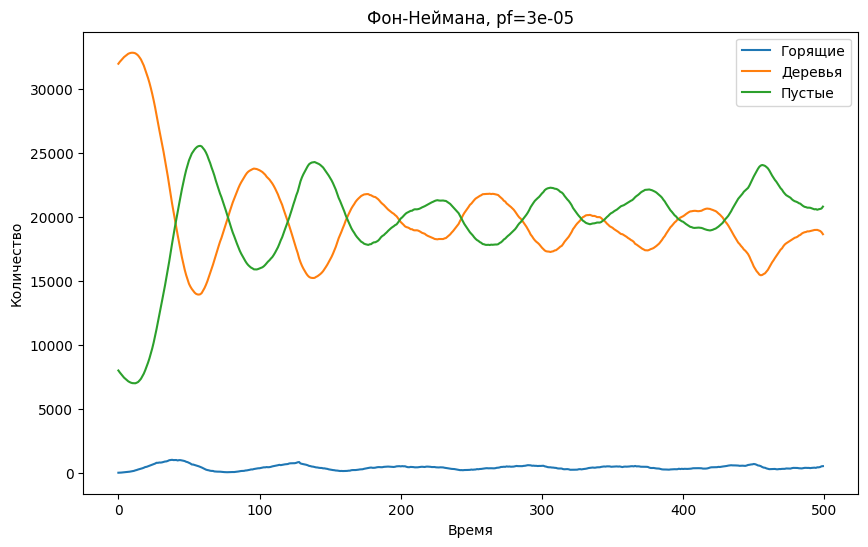

KeyboardInterrupt: 

In [11]:
w, h = 200, 200
eta = 0.8
f = 1
pg = 0.02
pf_values = [2e-5, 3e-5, 4e-5]
sim_time = 500
seed = 1097

for pf in pf_values:
    rs = np.random.RandomState(seed)
    ca = create_ca(w, h)
    ca = init_state(ca, eta, f, rs)
    stats_cross = simulate_ca(np.copy(ca), NeighborhoodType.CROSS, rs, pf, pg, sim_time)
    plot_statistics(stats_cross, f'Фон-Неймана, pf={pf}')
    stats_neuman = simulate_ca(np.copy(ca), NeighborhoodType.NEUMAN, rs, pf, pg, sim_time)
    plot_statistics(stats_neuman, f'Мура, pf={pf}')


In [21]:
w, h = 200, 200
eta = 0.8
f = 1
pg = 0.02
pf = 2e-5
sim_time = 150  
seed = 1097
rs = np.random.RandomState(seed)
ca = create_ca(w, h)
ca = init_state(ca, eta, f, rs)
animate_fire_evolution(ca, NeighborhoodType.CROSS, rs, pf, pg, sim_time, interval=100)


Анимация сохранена как fire_evolution.gif


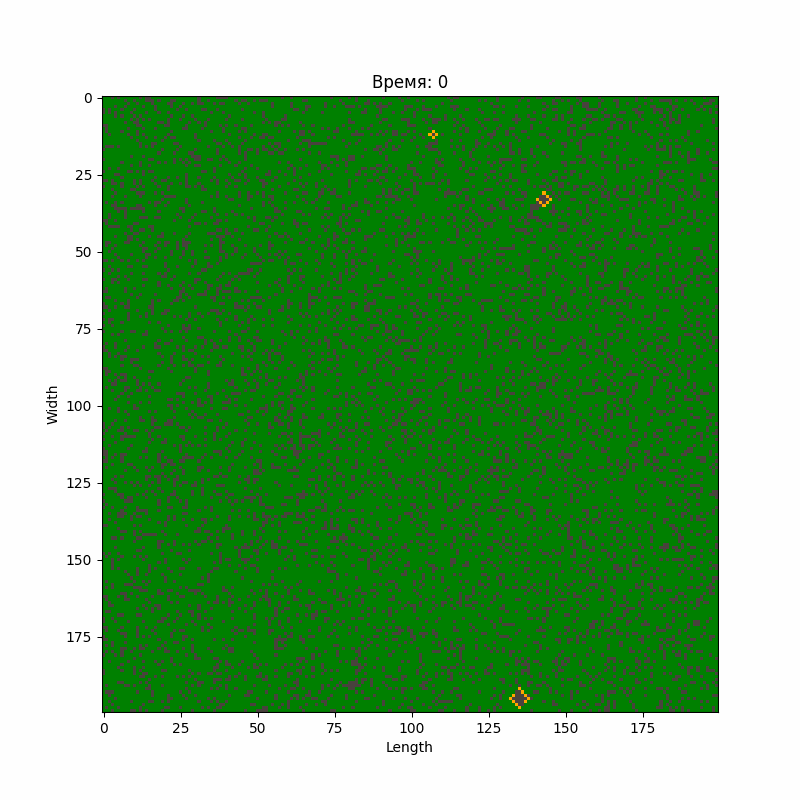

In [22]:
Image(filename="fire_evolution.gif")